<a href="https://colab.research.google.com/github/eliasedwin7/DTS_Final_Flights/blob/main/onpremises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US.

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ].

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine Learning (ML) is an appropriate solution for this problem for several reasons:

- **Volume of Data:** Given the extensive amount of flight data available from 2014 to 2018, traditional analytical methods would be insufficient and time-consuming. ML can handle and learn from large datasets more effectively.
- **Pattern Recognition:** Flight delays might be influenced by various factors, some of which might have complex interrelationships. ML can identify intricate patterns in data that might not be evident or even comprehensible to humans.
- **Predictive Analysis:** The primary goal is to predict flight delays, which is inherently a forward-looking task. ML is suited for predictive tasks as it can generalize from past data to make future predictions.
- **Improvement Over Time:** As more data becomes available, ML models can be retrained and improved, ensuring that the prediction remains relevant and accurate.

### 2. Formulate the business problem, success metrics, and desired ML output.

**Business Problem:**
The travel booking website aims to enhance the customer experience by alerting them about potential flight delays due to weather conditions. This predictive insight will allow customers to make more informed decisions when booking flights.

**Success Metrics:**
- **Accuracy:** The percentage of flights for which the delay status (delayed or not delayed) is predicted correctly.
- **False Positive Rate:** The percentage of flights that are predicted to be delayed but are not. This metric is crucial because falsely alerting a customer about a delay can lead to dissatisfaction.
- **Customer Satisfaction:** A qualitative metric that can be gauged through feedback or surveys after implementing the prediction feature.

**Desired ML Output:**
The ML model should output the probability of a flight being delayed. Based on a chosen threshold this can be classified as "Delayed" or "Not Delayed".


### 3. Identify the type of ML problem you’re dealing with.


This is a **binary classification** problem. The objective is to classify flights into one of two categories: "Delayed" or "Not Delayed" based on various features, primarily focusing on weather conditions.


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features?

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
#!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1QIG122Pb-h1Z2AFt4M-QHzecIxtgfLEt'
output = 'data.zip'
gdown.download(url, output, quiet=False)
!unzip data.zip


Downloading...
From: https://drive.google.com/uc?id=1QIG122Pb-h1Z2AFt4M-QHzecIxtgfLEt
To: /content/data.zip
100%|██████████| 1.53G/1.53G [00:18<00:00, 80.9MB/s]


Archive:  data.zip
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip  
 extracting: data_compressed/On_Time_Reporting_Carrier_On_Time_Perfor

In [3]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'data_compressed'
base_path = ''
csv_base_path = 'csv_base_path'

!mkdir -p {csv_base_path}

In [4]:
# How many zip files do we have? write a code to answer it.
import os

# List all files in the specified directory
all_files = os.listdir(zip_path)

# Filter the list to only include files with a .zip extension
zip_files = [file for file in all_files if file.endswith('.zip')]

# Count the number of ZIP files
num_zip_files = len(zip_files)

num_zip_files


60

#### Extract CSV files from ZIP files

In [5]:
from zipfile import ZipFile

def zip2csv(zipFile_name, file_path, base_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    base_path : path where the zip files are stored
    """
    full_zip_path = os.path.join(base_path, zipFile_name)

    try:
        with ZipFile(full_zip_path, 'r') as z:
            print(f'Extracting {zipFile_name} ...')
            z.extractall(path=file_path)
    except:
        print(f'zip2csv failed for {zipFile_name}')

# Ensure the zip_files list is populated
all_files = os.listdir(zip_path)
zip_files = [file for file in all_files if file.endswith('.zip')]

for file in zip_files:
    zip2csv(file, csv_base_path, zip_path)

print("Files Extracted")



Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_10.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_7.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_8.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_4.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_1.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_9.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_9.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_6.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_8.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_7.zip ...
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_pr

In [6]:
# How many csv files have we extracted? write a code to answer it.
# List all files in the specified directory
all_csv_files = os.listdir(csv_base_path)

# Filter the list to only include files with a .csv extension
csv_files = [file for file in all_csv_files if file.endswith('.csv')]

# Count the number of CSV files
num_csv_files = len(csv_files)

num_csv_files


60

Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [7]:
#from IPython.display import IFrame
#IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

from IPython.core.display import display, HTML

# Read the content of the HTML file
with open(f"{csv_base_path}/readme.html", 'r') as file:
    content = file.read()

# Display the HTML content in the notebook
display(HTML(content))


#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [8]:
import pandas as pd

# Construct the full path to the sample CSV file
sample_csv_path = os.path.join(csv_base_path, "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

# Read the sample CSV file into a Pandas DataFrame
df_temp = pd.read_csv(sample_csv_path)

# Display the first few rows of the DataFrame to get a sense of the data
df_temp.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print the row and column length in the dataset, and print the column names.

In [9]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [10]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [11]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:# **ENTER YOUR CODE HERE**
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not.

For example: `5 in [1,2,3,4,5]`

In [12]:
# Extract columns that contain the word 'Del'
delay_columns = [col for col in df_temp.columns if 'Del' in col]

print(delay_columns)


['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [13]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :" , df_temp['FlightDate'].min(), " to ", df_temp['FlightDate'].max())
print("The airlines covered in this dataset are: ", df_temp['Reporting_Airline'].unique().tolist())
print("The Origin airports covered are: ", df_temp['Origin'].unique().tolist())
print("The Destination airports covered are: ", df_temp['Dest'].unique().tolist())


The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [14]:
# Get counts for each origin and destination airport
origin_counts = df_temp['Origin'].value_counts()
dest_counts = df_temp['Dest'].value_counts()

# Store the counts in a DataFrame
counts = pd.DataFrame({'Origin': origin_counts, 'Destination': dest_counts})

counts


,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [15]:
# top 15 origin airports
print(" top 15 origin airports:\n",counts.sort_values(by='Origin', ascending=False).head(15))
# top 15 destinaton airports
print("\ntop 15 destination airports :\n",counts.sort_values(by='Destination', ascending=False).head(15))


 top 15 origin airports:
      Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877

top 15 destination airports :
      Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes, given the right features and a sufficiently large dataset, you can predict if a flight would be delayed using machine learning models. Flight delays can be influenced by a number of factors, including but not limited to weather conditions, air traffic, technical issues with the aircraft, and issues at either the departure or arrival airports. By training a model on historical data that includes these factors, the model can learn patterns and correlations that lead to delays, allowing it to make predictions on future flights.


Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe

In [17]:
from tqdm import tqdm
import pandas as pd

def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty list to store DataFrames
    dfs = []

    # Iterate over each CSV file using tqdm for progress bar
    for file in tqdm(csv_files, desc="Processing CSVs", unit="file"):
        # Read the CSV file into a dataframe
        df_temp = pd.read_csv(f"{csv_base_path}/{file}", usecols=filter_cols)

        # Filter rows based on subset_vals and subset_cols
        for col, vals in zip(subset_cols, subset_vals):
            df_temp = df_temp[df_temp[col].isin(vals)]

        # Append the DataFrame to the list
        dfs.append(df_temp)

    # Concatenate all DataFrames in the list
    df_combined = pd.concat(dfs, axis=0, ignore_index=True)

    # Optionally save the combined dataframe to a new CSV file
    #df_combined.to_csv(file_name, index=False)

    return df_combined


In [18]:
#cols is the list of columns to predict Arrival Delay
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily.

**Note**: This will take 5-7 minutes to complete.

In [19]:
start = time.time()

# Define the file name for the combined CSV
combined_csv_filename = f"{base_path}/combined_files.csv"

# Call the combine_csv function
combined_df = combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)


print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

Processing CSVs: 100%|██████████| 60/60 [03:00<00:00,  3.00s/file]


csv's merged in 3.01 minutes


#### Load dataset

Load the combined dataset.

In [20]:
data = combined_df# Enter your code here to read the combined csv file.

Print the first 5 records.

In [21]:
# Enter your code here
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,ArrDelay,ArrDelayMinutes,ArrDel15,Cancelled,Diverted,AirTime,Distance,DistanceGroup
0,2015,4,10,1,4,2015-10-01,AA,ORD,IL,CLT,NC,2149,-8.0,0.0,0.0,0.0,0.0,89.0,599.0,3
1,2015,4,10,2,5,2015-10-02,AA,ORD,IL,CLT,NC,2149,-6.0,0.0,0.0,0.0,0.0,98.0,599.0,3
2,2015,4,10,3,6,2015-10-03,AA,ORD,IL,CLT,NC,2149,-18.0,0.0,0.0,0.0,0.0,93.0,599.0,3
3,2015,4,10,4,7,2015-10-04,AA,ORD,IL,CLT,NC,2149,-15.0,0.0,0.0,0.0,0.0,88.0,599.0,3
4,2015,4,10,5,1,2015-10-05,AA,ORD,IL,CLT,NC,2145,-36.0,0.0,0.0,0.0,0.0,76.0,599.0,3


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [22]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", data['Year'].unique())
print("The months covered in this dataset are: ", data['Month'].unique())
print("The date range for data is :" , data['FlightDate'].min(), " to ", data['FlightDate'].max())
print("The airlines covered in this dataset are: ", data['Reporting_Airline'].unique().tolist())
print("The Origin airports covered are: ", data['Origin'].unique().tolist())
print("The Destination airports covered are: ", data['Dest'].unique().tolist())


The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2015 2017 2016 2014 2018]
The months covered in this dataset are:  [10  7  6  5  3  4 12  2  9  8 11  1]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['AA', 'DL', 'UA', 'OO', 'WN']
The Origin airports covered are:  ['ORD', 'SFO', 'DFW', 'LAX', 'PHX', 'IAH', 'DEN', 'ATL', 'CLT']
The Destination airports covered are:  ['CLT', 'DFW', 'SFO', 'ORD', 'PHX', 'LAX', 'ATL', 'DEN', 'IAH']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [23]:
# Rename the 'ArrDel15' column to 'is_delay'
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [24]:
# Enter your code here
# Check for null values in each column
null_counts = data.isnull().sum(axis=0)

# Print the number of null values in each column
print(null_counts)


Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
Cancelled                0
Diverted                 0
AirTime              22540
Distance                 0
DistanceGroup            0
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [25]:
### Remove null columns
# Remove rows with missing 'ArrDelay' and 'AirTime'
data = data.dropna(subset=['ArrDelay', 'AirTime'])

# Reset the index after removing rows
data.reset_index(drop=True, inplace=True)


Get the hour of the day in 24-hour time format from CRSDepTime.

In [26]:
# Convert 'CRSDepTime' to a string and slice the first 2 characters to get the hour
data['DepHourofDay'] = data['CRSDepTime'].astype(str).str.zfill(4).str[:2].astype(int)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm.

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

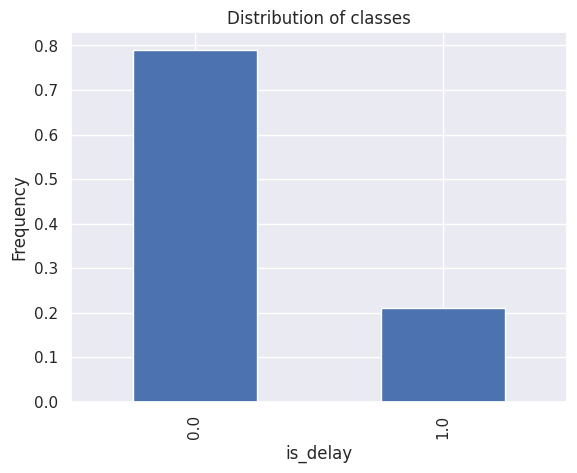

In [27]:
# Group the data by the 'is_delay' column and calculate the frequency
delay_distribution = (data.groupby('is_delay').size() / len(data)).plot(kind='bar')

# Add labels and title
plt.ylabel('Frequency')
plt.title('Distribution of classes')

# Show the plot
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

 From the bar plot about the ratio of delay vs. no delay it is understood that the frequency of flight being delayed is less. We can deduce that in the given dataset there is around 20% records with delayed flight records and almost 80% on time flight reords.

**Questions**:

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

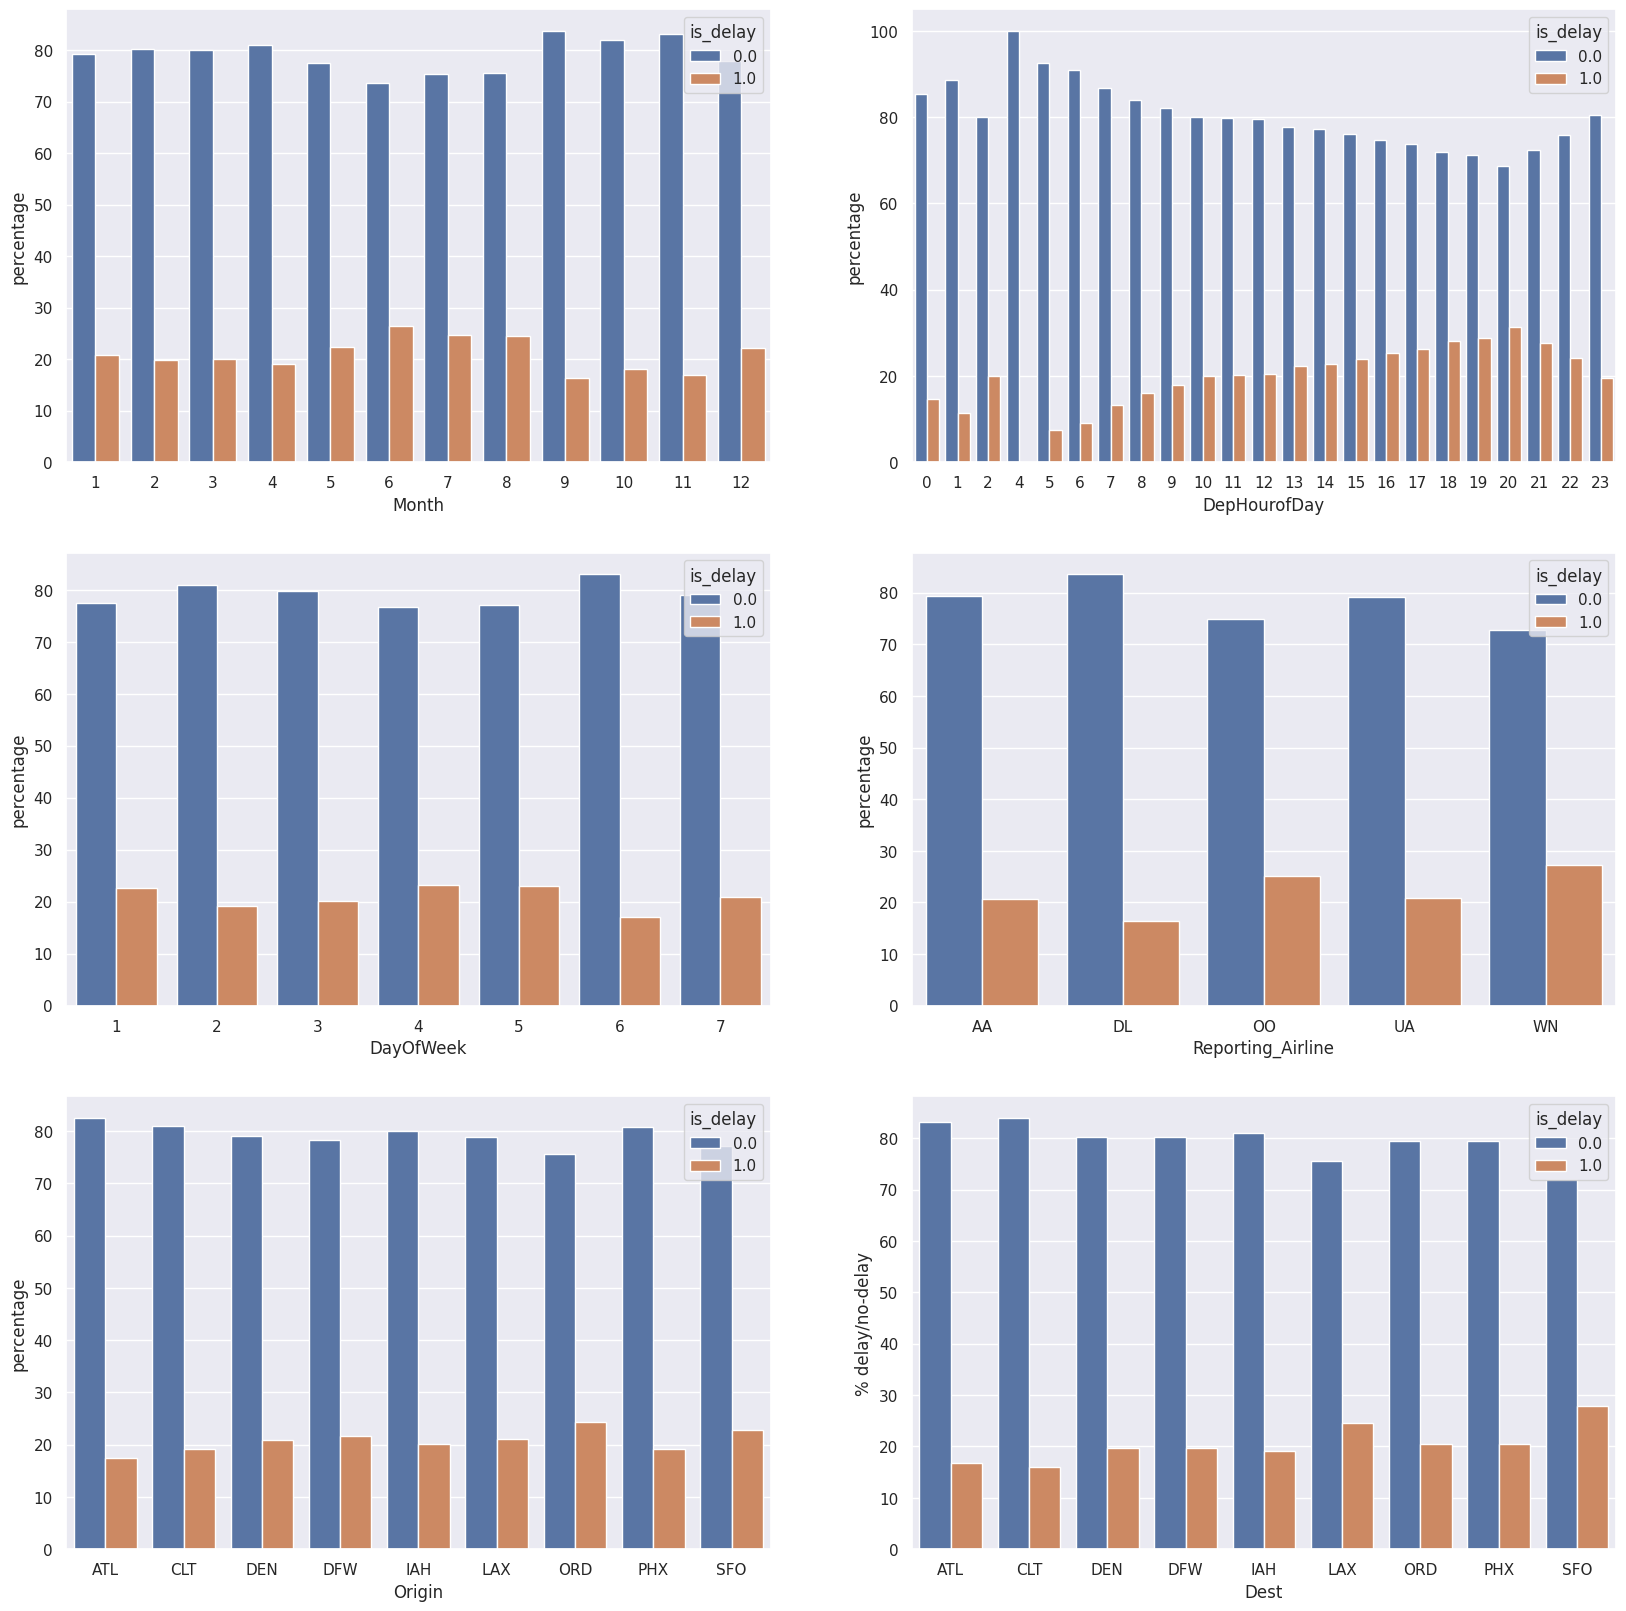

In [28]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')


plt.show()

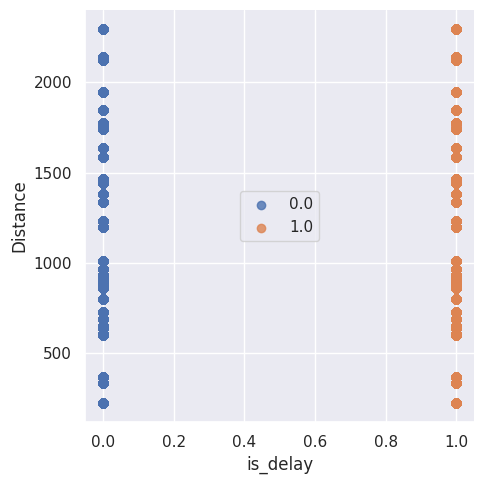

In [29]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

- Which months have the most delays?
  
  From the graph it is understood that the 6th month ,ie June has the most delays

- What time of the day has the most delays?

  From the graph we can deduct  that the 20th hour has the most delays

- What day of the week has the most delays?

  4th Day has the most delays

- Which airline has the most delays?

  The airline with code OO faced most delays


- Which origin and destination airports have the most delays?
  Origin : ORD
  Destination:SFO

- Is flight distance a factor in the delays?
There is a small negative trend ie , when flight distance decrease probabilty of getting a flight delay is more.

### Features

Look at all the columns and what their specific types are.

In [30]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup', 'DepHourofDay'],
      dtype='object')

In [31]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
Cancelled            float64
Diverted             float64
AirTime              float64
Distance             float64
DistanceGroup          int64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [32]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest'] #'DepHourofDay'
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [33]:
# Perform one-hot encoding on categorical columns
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate the one-hot encoded features to the original dataset
data = pd.concat([data, data_dummies], axis=1)
# Drop the original categorical columns
data.drop(categorical_columns + ['DepHourofDay'], axis=1, inplace=True)


Check the length of the dataset and the new columnms.

In [34]:
# Check the length of the dataset
data_length = len(data)
data_length

1635590

In [35]:
# Set the display option to show all columns
#pd.set_option('display.max_columns', None)

# Check the number of columns
columns = data.columns
columns

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:**
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [36]:
# Rename the column "is_delay" to "target"
data.rename(columns={'is_delay': 'target'}, inplace=True)
data.columns

Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Origin_CLT', 'Origin_DEN', '

In [37]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B

# Save the combined CSV file to your local computer
combined_csv_filename_v1 = 'combined_csv_v1.csv'
data.to_csv(combined_csv_filename_v1, index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [71]:
from sklearn.model_selection import train_test_split

# Define the feature columns (X) and target column (y)
X = data.drop(columns=['target'])
y = data['target']

# Splitting the data with a different random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


# Check the shapes of the resulting sets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (1308472, 85) (1308472,)
Testing data shape: (327118, 85) (327118,)


### Baseline classification model

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.79
Confusion Matrix:
 [[255941   2689]
 [ 66215   2273]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.99      0.88    258630
         1.0       0.46      0.03      0.06     68488

    accuracy                           0.79    327118
   macro avg       0.63      0.51      0.47    327118
weighted avg       0.72      0.79      0.71    327118



## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [73]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [74]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    auc = roc_auc_score(test_labels, target_predicted)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

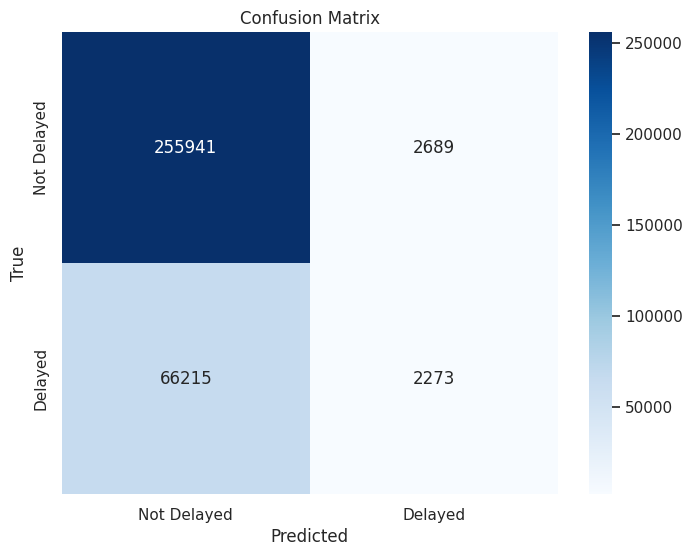

In [75]:
# Enter you code here
plot_confusion_matrix(y_test, y_pred)





To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

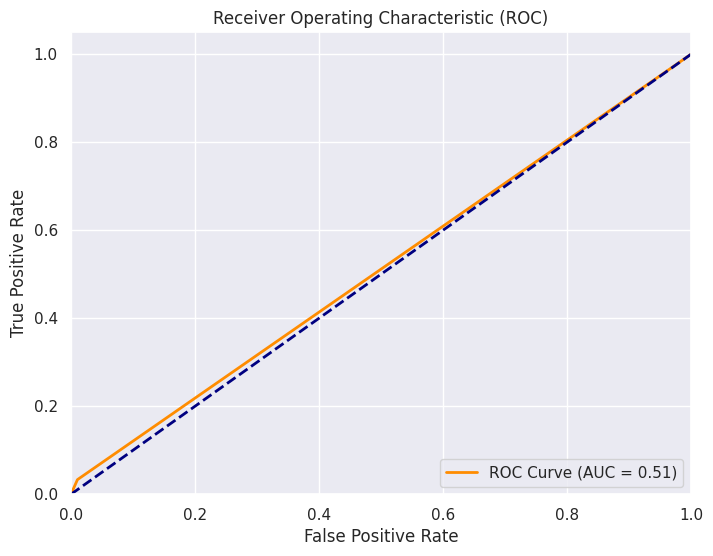

In [76]:
# Enter you code here
plot_roc(y_test, y_pred)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison?

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences?

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)?

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


From the confusion matrix:

- The model excels at correctly identifying class 0, with very few false positives (2,689).
- However, it struggles with class 1, often misclassifying them as class 0, leading to a high number of false negatives (66,215).
- Actual positive instances (class 1) are rarely predicted correctly, with only 2,273 true positives.

In essence, the model is heavily biased towards predicting class 0 and struggles to recognize class 1.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


In [45]:
### Provide a link for your Gitlab repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance?
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [46]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ]
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25']
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)


Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [47]:
# download data from the link above and place it into the data folder
import requests

# Define the URL to download the weather data
url = "https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the content (data) from the response
    weather_data = response.text

    # Save the weather data to a file in the Colab environment
    with open("daily-summaries.csv", "w") as file:
        file.write(weather_data)

    print("Weather data downloaded and saved as weather_data.csv.")
else:
    print("Failed to download weather data. Check the URL and try again.")


Weather data downloaded and saved as weather_data.csv.


Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [48]:
# Read the 'daily-summaries.csv' file
weather = pd.read_csv('daily-summaries.csv')

# Define the station and airport mappings
station = ['USW00023174', 'USW00012960', 'USW00003017', 'USW00094846', 'USW00013874', 'USW00023234', 'USW00003927', 'USW00023183', 'USW00013881']
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

# Create a dictionary to map weather stations to airports
station_map = dict(zip(station, airports))

# Map weather stations to airport codes
weather['airport'] = weather['STATION'].map(station_map)

# Display the first few rows of the weather data
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX


Create another column called `MONTH` from the `DATE` column.

In [49]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [50]:
weather['SNOW'].fillna(0, inplace=True)
weather['SNWD'].fillna(0, inplace=True)
weather.isna().sum()


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [51]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather['TAVG'].isna()]
TMAX_idx = idx[weather['TMAX'].isna()]
TMIN_idx = idx[weather['TMIN'].isna()]
TAVG_idx,TMAX_idx,TMIN_idx

(array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
         3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
         3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
         3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
         4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
         4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
         4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420]),
 array([10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771,
        10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780,
        10781, 10782]),
 array([10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771,
        10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780,
        10781, 10782]))

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [52]:
weather_impute = weather.groupby(['STATION','MONTH']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,STATION,MONTH,TAVG,TMAX,TMIN
0,USW00003017,01,-2.741935,74.000000,-69.858065
1,USW00003017,02,11.219858,88.553191,-65.035461


Merge the mean data with the weather data.

In [53]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG',
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX',
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [54]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [55]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [56]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [57]:
sum(data.isna().any())

0

In [58]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [59]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [60]:
data.to_csv('Tableu_combined_csv_v2.csv', index=False)

In [61]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
#categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [62]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [63]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [64]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
# Save the new combined CSV file
data.to_csv('combined_csv_v2.csv', index=False)

Create the training and testing sets again.

In [65]:
# Enter your code here
# Define features (X) and target (y)
X = data.drop(columns=['target'])
y = data['target']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1308472, 85)
X_test shape: (327118, 85)
y_train shape: (1308472,)
y_test shape: (327118,)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [66]:
# Instantiate another logistic regression model
classifier2 = LogisticRegression()

# Train the model on the training data
classifier2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.79
Confusion Matrix:
 [[255141   3276]
 [ 65942   2759]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.99      0.88    258417
         1.0       0.46      0.04      0.07     68701

    accuracy                           0.79    327118
   macro avg       0.63      0.51      0.48    327118
weighted avg       0.72      0.79      0.71    327118



Perform the evaluaion as you have done with the previous model and plot/show the same metrics

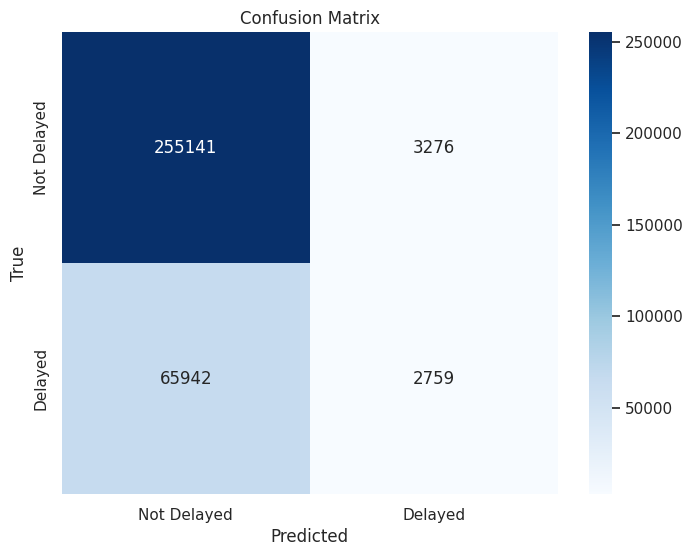

In [67]:
# Enter you code here
plot_confusion_matrix(y_test, y_pred)


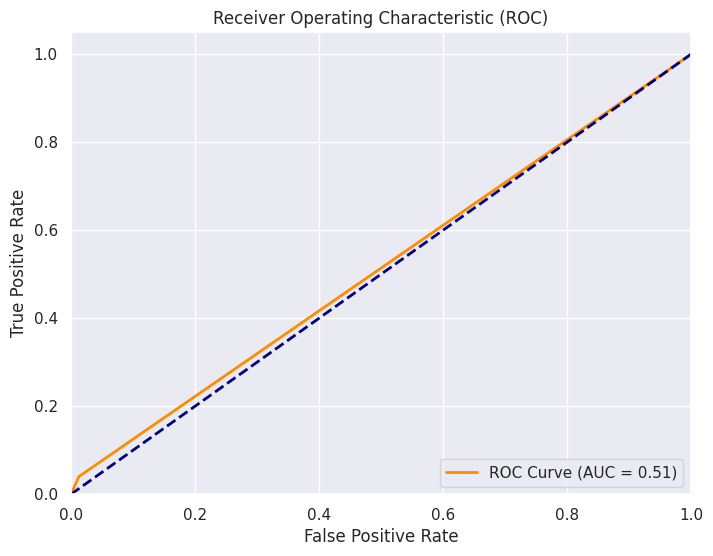

In [68]:
# Enter you code here
plot_roc(y_test, y_pred)

Question: did you notice a difference by adding the extra data on the results?

In [69]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem.
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

https://public.tableau.com/app/profile/edwin.alais/viz/Book1_16985334158800/Dashboard1?publish=yes

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [ ]:
# write your answers here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!mkdir -p "/content/drive/My Drive/Project_outputs"

!cp /content/combined_csv_v1.csv "/content/drive/My Drive/Project_outputs/combined_csv_v1.csv"
!cp /content/combined_csv_v2.csv "/content/drive/My Drive/Project_outputs/combined_csv_v2.csv"
